In [2]:
import pickle
from pathlib import Path
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import os

data_path = Path("/home/group01/mcv/datasets/MIT_split")
feature_path = Path("./results/retrieval")

In [3]:
with open(feature_path / "queries.npy", "rb") as f:
    query_data = np.load(f)
with open(feature_path / "catalogue.npy", "rb") as f:
    catalogue_data = np.load(f)

with (feature_path / "catalogue_meta.pkl").open('rb') as fc, \
        (feature_path / "query_meta.pkl").open('rb') as fq:
    catalogue_meta = pickle.load(fc)
    query_meta = pickle.load(fq)

query_labels = [x[1] for x in query_meta]
catalogue_labels = [x[1] for x in catalogue_meta]

In [4]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def pk(actual, predicted, k=10):
    """
    Computes the precision at k.
    This function computes the precision at k between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : int
             The element that has to be predicted
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The precision at k over the input
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0
    for i in range(len(predicted)):
        if actual == predicted[i]:
            score += 1
    
    return score / len(predicted)

def mpk(actual, predicted, k=10):
    """
    Computes the precision at k.
    This function computes the mean precision at k between a list of query images and a list
    of database retrieved images.
    Parameters
    ----------
    actual : list
             The query elements that have to be predicted
    predicted : list
                A list of predicted elements (order does matter) for each query element
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The precision at k over the input
    """
    pk_list = []
    for i in range(len(actual)):
        score = pk(actual[i], predicted[i], k)
        pk_list.append(score)
    return np.mean(pk_list)

def AP(actual, predicted):
    """
    Computes the precision at k.
    This function computes the average precision precision between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : int
             The element that has to be predicted
    predicted : list
                A list of predicted elements (order does matter)
    Returns
    -------
    score : double
            The Average Precision over the input
    """
    gtp = 0
    ap = 0
    for i in range(len(predicted)):
        a = pk(actual, predicted, i+1)
        if actual == predicted[i]: 
            b = 1
            gtp += 1
        else: 
            b = 0
        c = a*b
        ap += c

    if gtp == 0:
       return 0
    else:
        return ap/gtp

def mAP(actual, predicted):
    """
    Computes the precision at k.
    This function computes the mean Average Precision between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : list
             The query elements that have to be predicted
    predicted : list
                A list of predicted elements (order does matter) for each query element
    Returns
    -------
    score : double
            The mean Average Precision over the input
    """
    ap_list = []
    for i in range(len(actual)):
        ap = AP(actual[i], predicted[i])
        ap_list.append(ap)
    return np.mean(ap_list)

In [5]:
import matplotlib.pyplot as plt

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# precision recall curve
def plot_prec_rec_curve_multiclass(y_gt, y_pred, labels):
    precision = dict()
    recall = dict()
    aps = []
    for i in range(8):
        ap = average_precision_score(y_gt[:, i], y_pred[:, i])
        aps.append(ap)
        precision[i], recall[i], _ = precision_recall_curve(y_gt[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} - {ap:.3f}')
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve - mAP {np.mean(aps):.3f}")
    plt.show()

### K-nn L2

In [135]:
with open(feature_path / "KnnL2_results.pkl", "rb") as f:
        neighbors = pickle.load(f)

neighbors_labels = []
for i in range(len(neighbors)):
    neighbors_class = [catalogue_meta[j][1] for j in neighbors[i]]
    neighbors_labels.append(neighbors_class)

In [136]:
p_1 = mpk(query_labels,neighbors_labels, 1)
p_5 = mpk(query_labels,neighbors_labels, 5)
print('P@1=',p_1)
print('P@5=',p_5)

map = mAP(query_labels,neighbors_labels)
print('mAP=',map)

P@1= 0.3395291201982652
P@5= 0.3130111524163569
mAP= 0.45906994354949743


Calculate metrics for each class individually

In [116]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']

class_metrics = {}
for i in range(len(labels)):
    predictions = []
    gt = []
    for j in range(len(query_labels)):
        if query_labels[j]==i:
            predictions.append(neighbors_labels[j])
            gt.append(query_labels[j])
    
    p_1 = mpk(gt,predictions, 1)
    p_5 = mpk(gt,predictions, 5)
    print('Class: ', labels[i])
    print('P@1=',p_1)
    print('P@5=',p_5)
    map = mAP(gt,predictions)
    print('mAP=',map)
    class_metrics[labels[i]] = {'p_1': p_1, 'p_5': p_5, 'mAP': map}

Class:  Open Country
P@1= 0.2033898305084746
P@5= 0.22033898305084743
mAP= 0.34544491525423726
Class:  Coast
P@1= 0.07758620689655173
P@5= 0.08793103448275862
mAP= 0.18005268199233715
Class:  Forest
P@1= 0.5148514851485149
P@5= 0.4138613861386139
mAP= 0.6327007700770078
Class:  Highway
P@1= 0.2236842105263158
P@5= 0.22368421052631585
mAP= 0.33704312865497077
Class:  Inside City
P@1= 0.4148936170212766
P@5= 0.35319148936170214
mAP= 0.5333185579196219
Class:  Mountain
P@1= 0.4473684210526316
P@5= 0.4315789473684211
mAP= 0.572380604288499
Class:  Street
P@1= 0.4125
P@5= 0.3325
mAP= 0.5298437500000001
Class:  Tall Building
P@1= 0.4537037037037037
P@5= 0.45000000000000007
mAP= 0.5697402263374486


In [117]:
print(class_metrics)

{'Open Country': {'p_1': 0.2033898305084746, 'p_5': 0.22033898305084743, 'mAP': 0.34544491525423726}, 'Coast': {'p_1': 0.07758620689655173, 'p_5': 0.08793103448275862, 'mAP': 0.18005268199233715}, 'Forest': {'p_1': 0.5148514851485149, 'p_5': 0.4138613861386139, 'mAP': 0.6327007700770078}, 'Highway': {'p_1': 0.2236842105263158, 'p_5': 0.22368421052631585, 'mAP': 0.33704312865497077}, 'Inside City': {'p_1': 0.4148936170212766, 'p_5': 0.35319148936170214, 'mAP': 0.5333185579196219}, 'Mountain': {'p_1': 0.4473684210526316, 'p_5': 0.4315789473684211, 'mAP': 0.572380604288499}, 'Street': {'p_1': 0.4125, 'p_5': 0.3325, 'mAP': 0.5298437500000001}, 'Tall Building': {'p_1': 0.4537037037037037, 'p_5': 0.45000000000000007, 'mAP': 0.5697402263374486}}


In [73]:
neighbors[0][0]

644

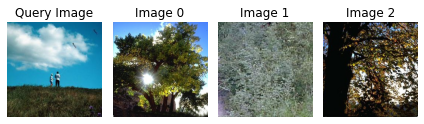

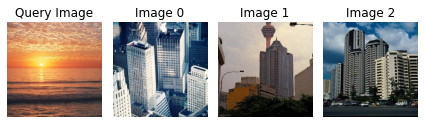

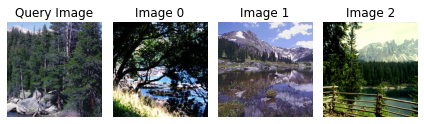

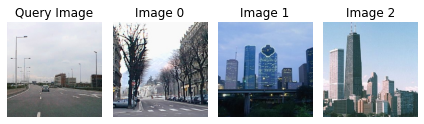

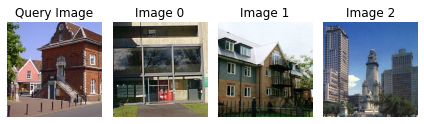

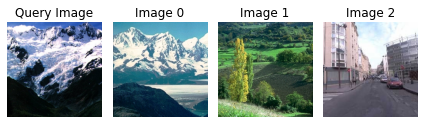

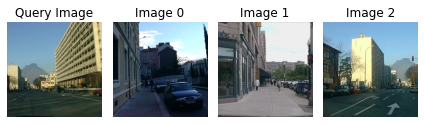

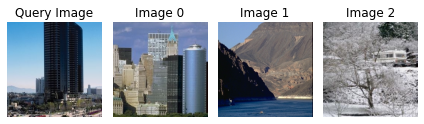

In [103]:
import matplotlib.image as mpimg
from PIL import Image
dataset_path = 'C:/Users/rachi/OneDrive/Documentos/Datasets/MIT_split/'
query_images = [0, 200, 300, 400, 500, 600, 650, 700]
labels = {0:'Opencountry',1: 'coast',2:'forest',3:'highway',4: 'inside_city', 5:'mountain', 6:'street', 7:'tallbuilding'}
img_out = "./results/retrieval/images/Knn"
for index in query_images:
    figures = {}
    img_path = dataset_path +'test/' +labels[query_meta[index][1]] + '/' + query_meta[index][0]
    figures['Query Image'] = Image.open(img_path)
    img_out2 = img_out + '/' + labels[query_meta[index][1]] + '/'
    os.makedirs(img_out2, exist_ok=True)
    img_name = '{:02d}_{}_{}'.format(0, labels[query_meta[index][1]], query_meta[index][0])
    img = figures['Query Image'].save(img_out2 + img_name)
    for i in range(3):
        j = neighbors[index][i]
        img_path = dataset_path +'train/' +labels[catalogue_meta[j][1]] + '/' + catalogue_meta[j][0]
        figures['Image '+str(i)] = Image.open(img_path)
        img_name = '{:02d}_{}_{}'.format(i+1, labels[catalogue_meta[j][1]], catalogue_meta[j][0])
        img = figures['Image '+str(i)].save(img_out2 + img_name)
    plot_figures(figures, 1, len(figures))

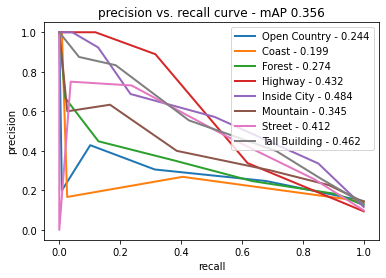

In [129]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']
Y = label_binarize(catalogue_labels, classes=[*range(8)])
Y_test = label_binarize(query_labels, classes=[*range(8)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, metric = "euclidean"))
clf.fit(catalogue_data, Y)

y_score_knn = clf.predict_proba(query_data)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, labels)

### Knn-L1

In [133]:
with open(feature_path / "KnnL1_results.pkl", "rb") as f:
        neighbors = pickle.load(f)

neighbors_labels = []
for i in range(len(neighbors)):
    neighbors_class = [catalogue_meta[j][1] for j in neighbors[i]]
    neighbors_labels.append(neighbors_class)

query_labels = [x[1] for x in query_meta]

In [134]:
p_1 = mpk(query_labels,neighbors_labels, 1)
p_5 = mpk(query_labels,neighbors_labels, 5)
print('P@1=',p_1)
print('P@5=',p_5)

map = mAP(query_labels,neighbors_labels)
print('mAP=',map)

P@1= 0.34076827757125155
P@5= 0.30805452292441143
mAP= 0.45544368718160533


Calculate metrics for each class individually

In [122]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']

class_metrics = {}
for i in range(len(labels)):
    predictions = []
    gt = []
    for j in range(len(query_labels)):
        if query_labels[j]==i:
            predictions.append(neighbors_labels[j])
            gt.append(query_labels[j])
    
    p_1 = mpk(gt,predictions, 1)
    p_5 = mpk(gt,predictions, 5)
    print('Class: ', labels[i])
    print('P@1=',p_1)
    print('P@5=',p_5)
    map = mAP(gt,predictions)
    print('mAP=',map)
    class_metrics[labels[i]] = {'p_1': p_1, 'p_5': p_5, 'mAP': map}

Class:  Open Country
P@1= 0.211864406779661
P@5= 0.235593220338983
mAP= 0.3763535781544256
Class:  Coast
P@1= 0.08620689655172414
P@5= 0.07586206896551721
mAP= 0.1596743295019157
Class:  Forest
P@1= 0.46534653465346537
P@5= 0.4475247524752475
mAP= 0.6186743674367436
Class:  Highway
P@1= 0.23684210526315788
P@5= 0.2131578947368421
mAP= 0.34616228070175437
Class:  Inside City
P@1= 0.4148936170212766
P@5= 0.348936170212766
mAP= 0.49909869976359345
Class:  Mountain
P@1= 0.4473684210526316
P@5= 0.3912280701754386
mAP= 0.5547880116959064
Class:  Street
P@1= 0.4375
P@5= 0.32
mAP= 0.5337326388888889
Class:  Tall Building
P@1= 0.46296296296296297
P@5= 0.4407407407407408
mAP= 0.582934670781893


In [123]:
print(class_metrics)

{'Open Country': {'p_1': 0.211864406779661, 'p_5': 0.235593220338983, 'mAP': 0.3763535781544256}, 'Coast': {'p_1': 0.08620689655172414, 'p_5': 0.07586206896551721, 'mAP': 0.1596743295019157}, 'Forest': {'p_1': 0.46534653465346537, 'p_5': 0.4475247524752475, 'mAP': 0.6186743674367436}, 'Highway': {'p_1': 0.23684210526315788, 'p_5': 0.2131578947368421, 'mAP': 0.34616228070175437}, 'Inside City': {'p_1': 0.4148936170212766, 'p_5': 0.348936170212766, 'mAP': 0.49909869976359345}, 'Mountain': {'p_1': 0.4473684210526316, 'p_5': 0.3912280701754386, 'mAP': 0.5547880116959064}, 'Street': {'p_1': 0.4375, 'p_5': 0.32, 'mAP': 0.5337326388888889}, 'Tall Building': {'p_1': 0.46296296296296297, 'p_5': 0.4407407407407408, 'mAP': 0.582934670781893}}


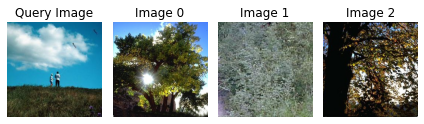

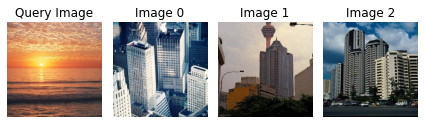

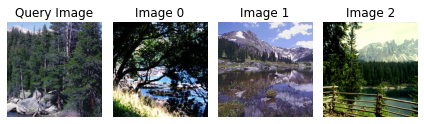

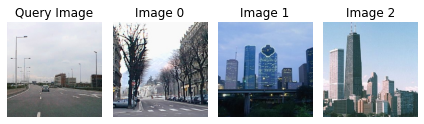

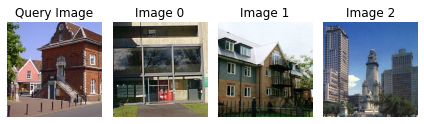

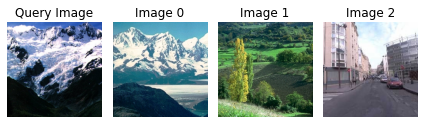

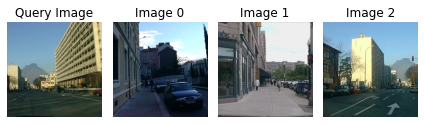

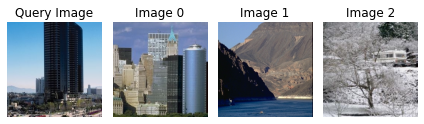

In [108]:
import matplotlib.image as mpimg
from PIL import Image
dataset_path = 'C:/Users/rachi/OneDrive/Documentos/Datasets/MIT_split/'
query_images = [0, 200, 300, 400, 500, 600, 650, 700]
labels = {0:'Opencountry',1: 'coast',2:'forest',3:'highway',4: 'inside_city', 5:'mountain', 6:'street', 7:'tallbuilding'}
img_out = "./results/retrieval/images/NN/"
for index in query_images:
    figures = {}
    img_path = dataset_path +'test/' +labels[query_meta[index][1]] + '/' + query_meta[index][0]
    figures['Query Image'] = Image.open(img_path)
    img_out2 = img_out + '/' + labels[query_meta[index][1]] + '/'
    os.makedirs(img_out2, exist_ok=True)
    img_name = '{:02d}_{}_{}'.format(0, labels[query_meta[index][1]], query_meta[index][0])
    img = figures['Query Image'].save(img_out2 + img_name)
    for i in range(3):
        j = neighbors[index][i]
        img_path = dataset_path +'train/' +labels[catalogue_meta[j][1]] + '/' + catalogue_meta[j][0]
        figures['Image '+str(i)] = Image.open(img_path)
        img_name = '{:02d}_{}_{}'.format(i+1, labels[catalogue_meta[j][1]], catalogue_meta[j][0])
        img = figures['Image '+str(i)].save(img_out2 + img_name)
    plot_figures(figures, 1, len(figures))

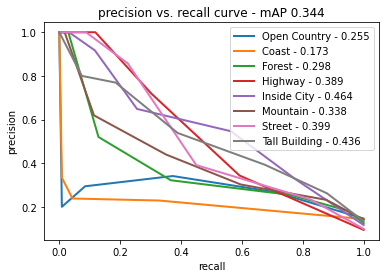

In [131]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']
Y = label_binarize(catalogue_labels, classes=[*range(8)])
Y_test = label_binarize(query_labels, classes=[*range(8)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, metric = "manhattan"))
clf.fit(catalogue_data, Y)

y_score_knn = clf.predict_proba(query_data)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, labels)

### K-nn L2 after adding eval()

In [28]:
with open(feature_path / "KnnL2_results_new.pkl", "rb") as f:
        neighbors = pickle.load(f)

neighbors_labels = []
for i in range(len(neighbors)):
    neighbors_class = [catalogue_meta[j][1] for j in neighbors[i]]
    neighbors_labels.append(neighbors_class)

In [8]:
p_1 = mpk(query_labels,neighbors_labels, 1)
p_5 = mpk(query_labels,neighbors_labels, 5)
print('P@1=',p_1)
print('P@5=',p_5)

map = mAP(query_labels,neighbors_labels)
print('mAP=',map)

P@1= 0.8884758364312267
P@5= 0.8802973977695167
mAP= 0.9183395291201983


Calculate metrics for each class individually

In [9]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']

class_metrics = {}
for i in range(len(labels)):
    predictions = []
    gt = []
    for j in range(len(query_labels)):
        if query_labels[j]==i:
            predictions.append(neighbors_labels[j])
            gt.append(query_labels[j])
    
    p_1 = mpk(gt,predictions, 1)
    p_5 = mpk(gt,predictions, 5)
    print('Class: ', labels[i])
    print('P@1=',p_1)
    print('P@5=',p_5)
    map = mAP(gt,predictions)
    print('mAP=',map)
    class_metrics[labels[i]] = {'p_1': p_1, 'p_5': p_5, 'mAP': map}

Class:  Open Country
P@1= 0.7203389830508474
P@5= 0.6915254237288135
mAP= 0.7893596986817325
Class:  Coast
P@1= 0.9482758620689655
P@5= 0.9396551724137931
mAP= 0.9637811302681991
Class:  Forest
P@1= 0.8712871287128713
P@5= 0.8910891089108911
mAP= 0.9212458745874589
Class:  Highway
P@1= 0.9605263157894737
P@5= 0.9473684210526315
mAP= 0.9623903508771929
Class:  Inside City
P@1= 0.851063829787234
P@5= 0.8234042553191487
mAP= 0.8791666666666667
Class:  Mountain
P@1= 0.9298245614035088
P@5= 0.9175438596491227
mAP= 0.9520955165692008
Class:  Street
P@1= 0.9
P@5= 0.8949999999999999
mAP= 0.9218923611111112
Class:  Tall Building
P@1= 0.9537037037037037
P@5= 0.9648148148148147
mAP= 0.9725694444444444


In [10]:
print(class_metrics)

{'Open Country': {'p_1': 0.7203389830508474, 'p_5': 0.6915254237288135, 'mAP': 0.7893596986817325}, 'Coast': {'p_1': 0.9482758620689655, 'p_5': 0.9396551724137931, 'mAP': 0.9637811302681991}, 'Forest': {'p_1': 0.8712871287128713, 'p_5': 0.8910891089108911, 'mAP': 0.9212458745874589}, 'Highway': {'p_1': 0.9605263157894737, 'p_5': 0.9473684210526315, 'mAP': 0.9623903508771929}, 'Inside City': {'p_1': 0.851063829787234, 'p_5': 0.8234042553191487, 'mAP': 0.8791666666666667}, 'Mountain': {'p_1': 0.9298245614035088, 'p_5': 0.9175438596491227, 'mAP': 0.9520955165692008}, 'Street': {'p_1': 0.9, 'p_5': 0.8949999999999999, 'mAP': 0.9218923611111112}, 'Tall Building': {'p_1': 0.9537037037037037, 'p_5': 0.9648148148148147, 'mAP': 0.9725694444444444}}


In [12]:
neighbors[0][0]

200

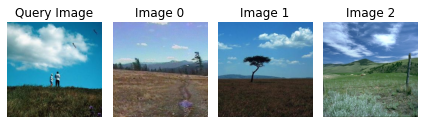

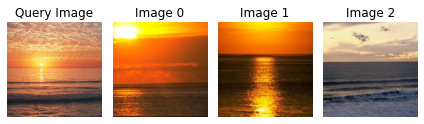

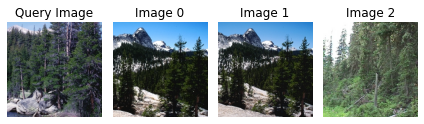

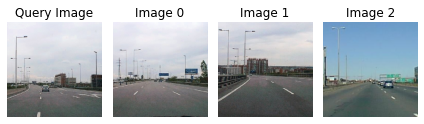

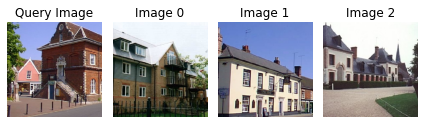

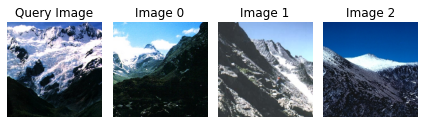

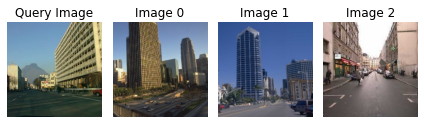

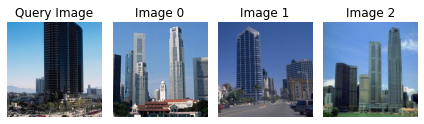

In [31]:
import matplotlib.image as mpimg
from PIL import Image
dataset_path = 'C:/Users/rachi/OneDrive/Documentos/Datasets/MIT_split/'
query_images = [0, 200, 300, 400, 500, 600, 650, 700]
labels = {0:'Opencountry',1: 'coast',2:'forest',3:'highway',4: 'inside_city', 5:'mountain', 6:'street', 7:'tallbuilding'}
img_out = "./results/retrieval/images/Knn_L2"
for index in query_images:
    figures = {}
    img_path = dataset_path +'test/' +labels[query_meta[index][1]] + '/' + query_meta[index][0]
    figures['Query Image'] = Image.open(img_path)
    img_out2 = img_out + '/' + labels[query_meta[index][1]] + '/'
    os.makedirs(img_out2, exist_ok=True)
    img_name = '{:02d}_{}_{}'.format(0, labels[query_meta[index][1]], query_meta[index][0])
    img = figures['Query Image'].save(img_out2 + img_name)
    for i in range(3):
        j = neighbors[index][i]
        img_path = dataset_path +'train/' +labels[catalogue_meta[j][1]] + '/' + catalogue_meta[j][0]
        figures['Image '+str(i)] = Image.open(img_path)
        img_name = '{:02d}_{}_{}'.format(i+1, labels[catalogue_meta[j][1]], catalogue_meta[j][0])
        img = figures['Image '+str(i)].save(img_out2 + img_name)
    plot_figures(figures, 1, len(figures))

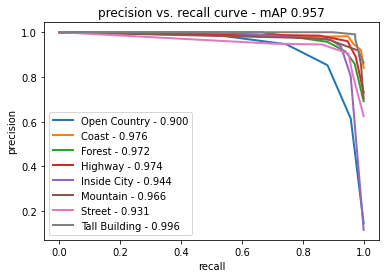

In [33]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']
Y = label_binarize(catalogue_labels, classes=[*range(8)])
Y_test = label_binarize(query_labels, classes=[*range(8)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, metric = "euclidean"))
clf.fit(catalogue_data, Y)

y_score_knn = clf.predict_proba(query_data)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, labels)

### K-nn L1 after adding eval()

In [15]:
with open(feature_path / "KnnL1_results_new.pkl", "rb") as f:
        neighbors = pickle.load(f)

neighbors_labels = []
for i in range(len(neighbors)):
    neighbors_class = [catalogue_meta[j][1] for j in neighbors[i]]
    neighbors_labels.append(neighbors_class)

In [16]:
p_1 = mpk(query_labels,neighbors_labels, 1)
p_5 = mpk(query_labels,neighbors_labels, 5)
print('P@1=',p_1)
print('P@5=',p_5)

map = mAP(query_labels,neighbors_labels)
print('mAP=',map)

P@1= 0.895910780669145
P@5= 0.8721189591078067
mAP= 0.9178300977557483


Calculate metrics for each class individually

In [18]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']

class_metrics = {}
for i in range(len(labels)):
    predictions = []
    gt = []
    for j in range(len(query_labels)):
        if query_labels[j]==i:
            predictions.append(neighbors_labels[j])
            gt.append(query_labels[j])
    
    p_1 = mpk(gt,predictions, 1)
    p_5 = mpk(gt,predictions, 5)
    print('Class: ', labels[i])
    print('P@1=',p_1)
    print('P@5=',p_5)
    map = mAP(gt,predictions)
    print('mAP=',map)
    class_metrics[labels[i]] = {'p_1': p_1, 'p_5': p_5, 'mAP': map}

Class:  Open Country
P@1= 0.7542372881355932
P@5= 0.6813559322033897
mAP= 0.7877236346516006
Class:  Coast
P@1= 0.9655172413793104
P@5= 0.9413793103448276
mAP= 0.9670617816091954
Class:  Forest
P@1= 0.8910891089108911
P@5= 0.8970297029702969
mAP= 0.9248349834983498
Class:  Highway
P@1= 0.9605263157894737
P@5= 0.9342105263157895
mAP= 0.9754568713450292
Class:  Inside City
P@1= 0.851063829787234
P@5= 0.8042553191489361
mAP= 0.8765218676122932
Class:  Mountain
P@1= 0.9122807017543859
P@5= 0.9035087719298246
mAP= 0.9443469785575048
Class:  Street
P@1= 0.9
P@5= 0.8724999999999999
mAP= 0.9144965277777779
Class:  Tall Building
P@1= 0.9537037037037037
P@5= 0.9648148148148148
mAP= 0.970434670781893


In [19]:
print(class_metrics)

{'Open Country': {'p_1': 0.7542372881355932, 'p_5': 0.6813559322033897, 'mAP': 0.7877236346516006}, 'Coast': {'p_1': 0.9655172413793104, 'p_5': 0.9413793103448276, 'mAP': 0.9670617816091954}, 'Forest': {'p_1': 0.8910891089108911, 'p_5': 0.8970297029702969, 'mAP': 0.9248349834983498}, 'Highway': {'p_1': 0.9605263157894737, 'p_5': 0.9342105263157895, 'mAP': 0.9754568713450292}, 'Inside City': {'p_1': 0.851063829787234, 'p_5': 0.8042553191489361, 'mAP': 0.8765218676122932}, 'Mountain': {'p_1': 0.9122807017543859, 'p_5': 0.9035087719298246, 'mAP': 0.9443469785575048}, 'Street': {'p_1': 0.9, 'p_5': 0.8724999999999999, 'mAP': 0.9144965277777779}, 'Tall Building': {'p_1': 0.9537037037037037, 'p_5': 0.9648148148148148, 'mAP': 0.970434670781893}}


In [20]:
neighbors[0][0]

1

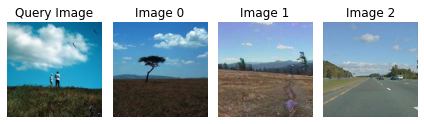

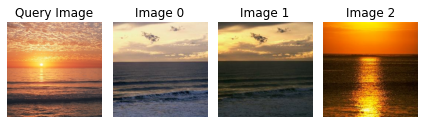

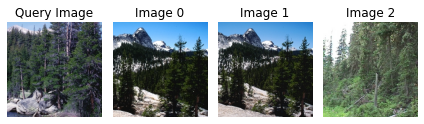

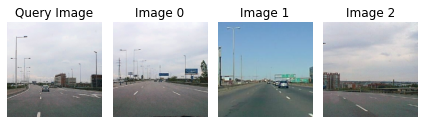

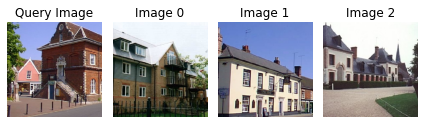

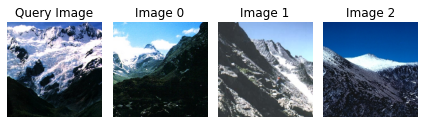

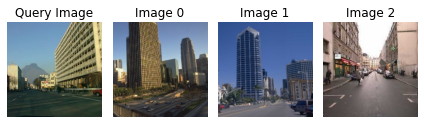

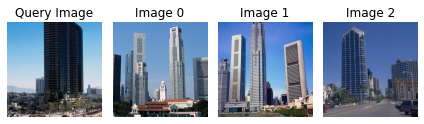

In [23]:
import matplotlib.image as mpimg
from PIL import Image
dataset_path = 'C:/Users/rachi/OneDrive/Documentos/Datasets/MIT_split/'
query_images = [0, 200, 300, 400, 500, 600, 650, 700]
labels = {0:'Opencountry',1: 'coast',2:'forest',3:'highway',4: 'inside_city', 5:'mountain', 6:'street', 7:'tallbuilding'}
img_out = "./results/retrieval/images/Knn_L1"
for index in query_images:
    figures = {}
    img_path = dataset_path +'test/' +labels[query_meta[index][1]] + '/' + query_meta[index][0]
    figures['Query Image'] = Image.open(img_path)
    img_out2 = img_out + '/' + labels[query_meta[index][1]] + '/'
    os.makedirs(img_out2, exist_ok=True)
    img_name = '{:02d}_{}_{}'.format(0, labels[query_meta[index][1]], query_meta[index][0])
    img = figures['Query Image'].save(img_out2 + img_name)
    for i in range(3):
        j = neighbors[index][i]
        img_path = dataset_path +'train/' +labels[catalogue_meta[j][1]] + '/' + catalogue_meta[j][0]
        figures['Image '+str(i)] = Image.open(img_path)
        img_name = '{:02d}_{}_{}'.format(i+1, labels[catalogue_meta[j][1]], catalogue_meta[j][0])
        img = figures['Image '+str(i)].save(img_out2 + img_name)
    plot_figures(figures, 1, len(figures))

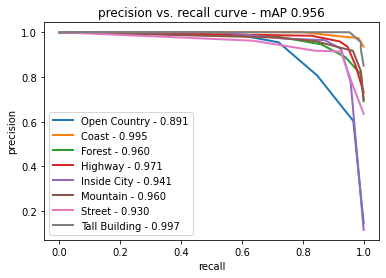

In [32]:
labels = ['Open Country', 'Coast', 'Forest', 'Highway', 'Inside City', 'Mountain', 'Street', 'Tall Building']
Y = label_binarize(catalogue_labels, classes=[*range(8)])
Y_test = label_binarize(query_labels, classes=[*range(8)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, metric = "manhattan"))
clf.fit(catalogue_data, Y)

y_score_knn = clf.predict_proba(query_data)
plot_prec_rec_curve_multiclass(Y_test, y_score_knn, labels)